Quantum Fourier Transform Benchmark Program - Braket
... using circuit method 2
... execution starting at Sep 20, 2024 06:34:13 UTC
************
Executing [3] circuits with num_qubits = 2
... number of gates, depth = 12, 6
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 7, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 7, 0, 0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.001, 0.017, 0.017 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 3
... number of gates, depth = 24, 11
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 14, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 14, 0, 0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.013, 0.013 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with 

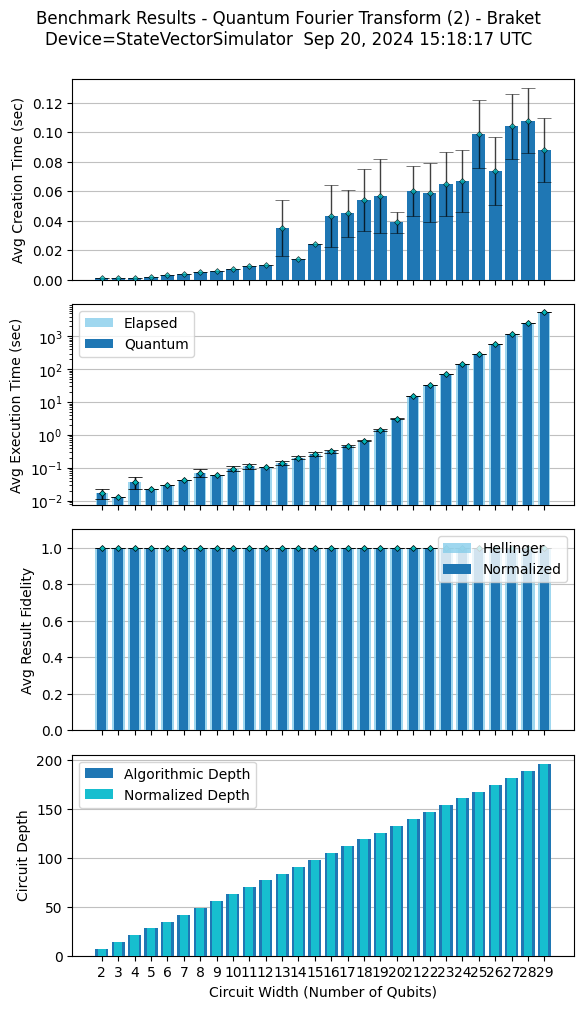

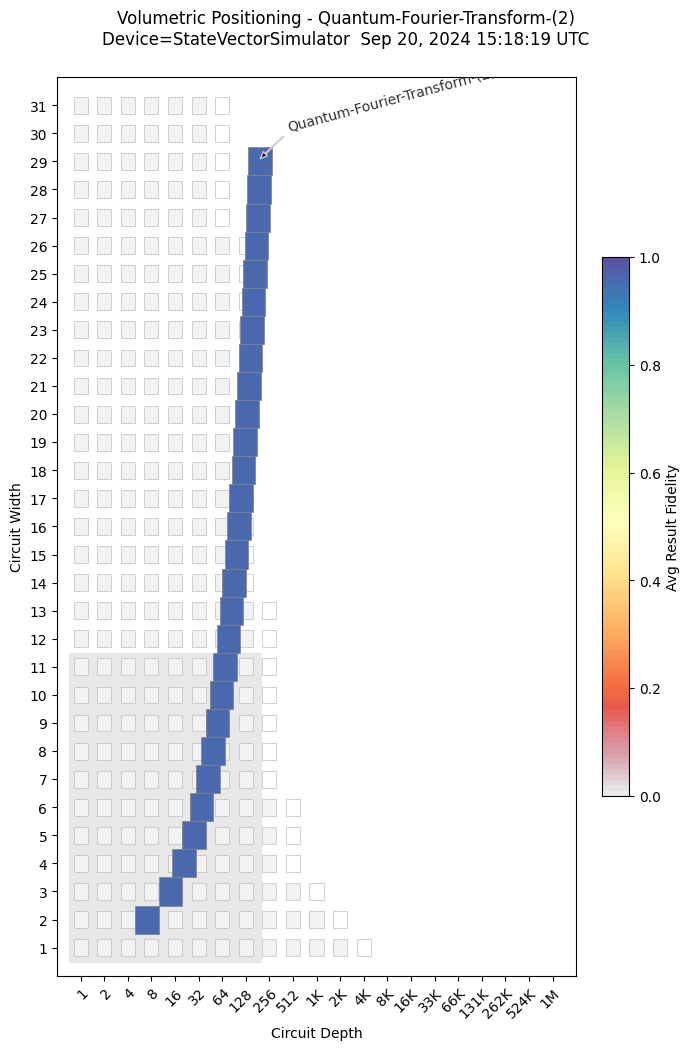

In [1]:
"""
Quantum Fourier Transform Benchmark Program - Braket
"""

import sys
import time

from braket.circuits import Circuit     # AWS imports: Import Braket SDK modules
import math
import numpy as np

sys.path[1:1] = [ "_common", "_common/braket" ]
sys.path[1:1] = [ "../../_common", "../../_common/braket" ]
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
num_gates = 0
depth = 0
QC_ = None
QFT_ = None
QFTI_ = None

############### Circuit Definition

def QuantumFourierTransform (num_qubits, secret_int, method=1):
    global num_gates, depth
    # Size of input is one less than available qubits
    input_size = num_qubits
    num_gates = 0
    depth = 0
    
    # allocate circuit
    qc = Circuit()
     
    if method==1:

        # Perform X on each qubit that matches a bit in secret string
        s = ('{0:0'+str(input_size)+'b}').format(secret_int)
        for i_qubit in range(input_size):
            if s[input_size-1-i_qubit]=='1':
                qc.x(i_qubit)
                num_gates += 1
                
        depth += 1

        # perform QFT on the input 
        qft = qft_gate(input_size)
        qc.add(qft)

        # End with Hadamard on all qubits (to measure the z rotations)
        ''' don't do this unless NOT doing the inverse afterwards
        for i_qubit in range(input_size):
             qc.h(i_qubit)
        '''

        # some compilers recognize the QFT and IQFT in series and collapse them to identity;
        # perform a set of rotations to add one to the secret_int to avoid this collapse
        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz(i_q, 1 * math.pi / divisor)
            num_gates+=1
        
        # to revert back to initial state, apply inverse QFT
        qfti = inv_qft_gate(input_size)
        qc.add(qfti)

    elif method == 2:

        for i_q in range(0, num_qubits):
            qc.h(i_q)
            num_gates += 1

        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz(i_q, secret_int * math.pi / divisor)
            num_gates += 1

        depth += 1

        qfti = inv_qft_gate(input_size)
        qc.add(qfti)

    # This method is a work in progress
    elif method == 3:

        for i_q in range(0, secret_int):
            qc.h(i_q)
            num_gates += 1

        for i_q in range(secret_int, num_qubits):
            qc.x(i_q)
            num_gates += 1

        depth += 1

        qfti = inv_qft_gate(input_size)
        qc.add(qfti)

    else:
        exit("Invalid QFT method")

    num_gates += num_qubits
    depth += 1

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

############### QFT Circuit

def qft_gate(input_size):
    global QFT_, num_gates, depth
    qc = Circuit()
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in range(0, input_size):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in range(0, num_crzs):
                divisor = 2 ** (num_crzs - j)
                #qc.crz(hidx, math.pi / divisor , input_size - j - 1)
                crz_gate(qc, math.pi / divisor, hidx, input_size - j - 1)
                num_gates += 1
                depth += 1
            
        # followed by an H gate (applied to all qubits)
        qc.h(hidx)
        num_gates += 1
        depth += 1
        
        #qc.barrier()
    
    if QFT_ == None or input_size <= 5:
        if input_size < 9: QFT_ = qc
        
    return qc 
        
############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qc = Circuit()
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(hidx)
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                #qc.crz( -math.pi / divisor , hidx, input_size - j - 1)
                crz_gate(qc, -math.pi / divisor, hidx, input_size - j - 1)
                num_gates += 1
                depth += 1

    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_= qc
        
    return qc
  
 
############### CRZ shim
 
# Implement the CRZ with RZs and CNOTs
def crz_gate(qc, theta, control_qubit, target_qubit):
    qc.rz(target_qubit, theta/2)
    qc.cnot(control_qubit, target_qubit)
    qc.rz(target_qubit, -theta/2)
    qc.cnot(control_qubit, target_qubit)

    global num_gates, depth
    num_gates += 3
    depth += 1

############### Result Data Analysis

# Define expected distribution calculated from applying the iqft to the prepared secret_int state
def expected_dist(num_qubits, secret_int, counts):
    dist = {}
    s = num_qubits - secret_int
    for key in counts.keys():
        key_r = key[::-1] 
        # for braket, need to reverse the key to compare against secret int
        if key_r[(num_qubits-secret_int):] == ''.zfill(secret_int):
            dist[key] = 1/(2**s)
    return dist
    
# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int, method):

    # obtain shots from the result metadata
    num_shots = result.task_metadata.shots

    # obtain counts from the result object
    counts = result.measurement_counts
    
    # For method 1, expected result is always the secret_int
    if method==1:
        
        # add one to the secret_int to compensate for the extra rotations done between QFT and IQFT
        secret_int_plus_one = (secret_int + 1) % (2 ** num_qubits)

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int_plus_one, f"0{num_qubits}b")
        key_r = key[::-1]   

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key_r: 1.0}
        
    # For method 2, expected result is always the secret_int
    elif method==2:

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int, f"0{num_qubits}b")
        key_r = key[::-1]   

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key_r: 1.0}
    
    # For method 3, correct_dist is a distribution with more than one value
    elif method==3:

        # correct_dist is from the expected dist
        correct_dist = expected_dist(num_qubits, secret_int, counts)
            
    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    if verbose: print(f"For secret int {secret_int} measured: {counts} fidelity: {fidelity}")

    return counts, fidelity

################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits = 2, max_qubits = 29, max_circuits = 3, num_shots = 1000,
        method=2,
        backend_id = 'simulator'):

    print("Quantum Fourier Transform Benchmark Program - Braket")
    print(f"... using circuit method {method}")
    
    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, input_size, s_int):  
     
        # determine fidelity of result set
        num_qubits = int(input_size)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), method)
        metrics.store_metric(input_size, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1):
        
        num_qubits = input_size

        # determine number of circuits to execute for this group
        # and determine range of secret strings to loop over
        if method == 1 or method == 2:
            num_circuits = min(2 ** (input_size), max_circuits)
        
            if 2**(input_size) <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(2**(input_size), num_circuits, False)

        elif method == 3:
            num_circuits = min(input_size, max_circuits)
        
            if input_size <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(range(input_size), num_circuits, False)

        else:
            exit("Invalid QFT method")

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
        
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = QuantumFourierTransform(num_qubits, s_int, method=method)
            metrics.store_metric(input_size, s_int, 'create_time', time.time()-ts)
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, input_size, s_int, shots=num_shots)
        
        print(f"... number of gates, depth = {num_gates}, {depth}")
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(input_size)
        metrics.report_metrics_for_group(input_size)

    # Alternatively, execute all circuits, aggregate and report metrics
    #ex.execute_circuits()
    #metrics.aggregate_metrics_for_group(input_size)
    #metrics.report_metrics_for_group(input_size)

    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method==1:
        print("\nQFT Circuit ="); print(QFT_ if QFT_ != None else "  ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QFTI_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - Quantum Fourier Transform ({method}) - Braket")

# if main, execute method    
if __name__ == '__main__': run()
